# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [54]:
import pandas as pd
import numpy as np

In [55]:
# Load the dataset
def import_csv(path: str) -> pd.DataFrame:
    """
    Imports a file given a path
    """
    return pd.read_csv(path, header='infer', na_values='?')

data = import_csv("adult.csv")
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [56]:
# Drop null values
def drop_nulls(dataset: pd.DataFrame, print_stats: bool = False) -> pd.DataFrame:
    """
    Drops None or NaN values in the dataset.
    """
    init_size = dataset.shape[0]
    dataset = dataset.dropna()
    assert dataset.notna().all().all() # No None or NaN
    curr_size = dataset.shape[0]
    if print_stats:
        print("Filtered " + str(init_size - curr_size) + "/" + str(init_size) + " rows")
    return dataset

data = drop_nulls(data, True)

Filtered 3620/48842 rows


In [57]:
# Get unique values per column
def unique_vals_per_col(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Returns the unique values in a column.
    """
    return dataset.apply(pd.unique) # Returns a series object with the unique values per column + column title


In [59]:
# Fix target values consistency
def preprocess_adult_dataset(dataset: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Preprocesses the adult dataset by:
    - Fixing the target label consistency
    - Dropping columns
    """
    for col in columns:
        assert col in dataset.columns

    dataset['salary'] = dataset['salary'].str.rstrip('.') # The target label has a bunch of "." characters at the end
    dataset['salary'] = pd.Categorical(dataset['salary']).codes

    return dataset.drop(columns=columns)

data = preprocess_adult_dataset(data, ['education', 'fnlwgt', 'native-country'])

In [60]:
data

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,salary
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,Private,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,0
48837,39,Private,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,0
48839,38,Private,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,0
48840,44,Private,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,0


### Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable.

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf).

<!-- #### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec).

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers. -->

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models.

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split

In [62]:
# Define your preprocessing steps here
steps = [('ordinal', OrdinalEncoder(), ["workclass", "marital-status", "occupation", "relationship", "race", "sex"]),
         ('min-max-scaling', MinMaxScaler(), ["age", "capital-gain", "capital-loss", "hours-per-week"]),
         ('passthrough', 'passthrough', ['education-num'])
        ]

# Label Encoding - One-Hot would be far too large - Curse of Dimensionality
# MinMax Scaling - Lots of Continuous-ish features
# Drop fnwlgt - measure purely of an individual with how much they are like others - no inherent characteristic of individual
# Drop education - education-num is a numerical representation of the same thing
# Drop native-country - 90% of values are US, and generally not informative
# No dropping of features like race, sex - we do not make decisions as of now - not necessary for the task at hand

# Combine steps into a ColumnTransformer
ct = ColumnTransformer(steps)


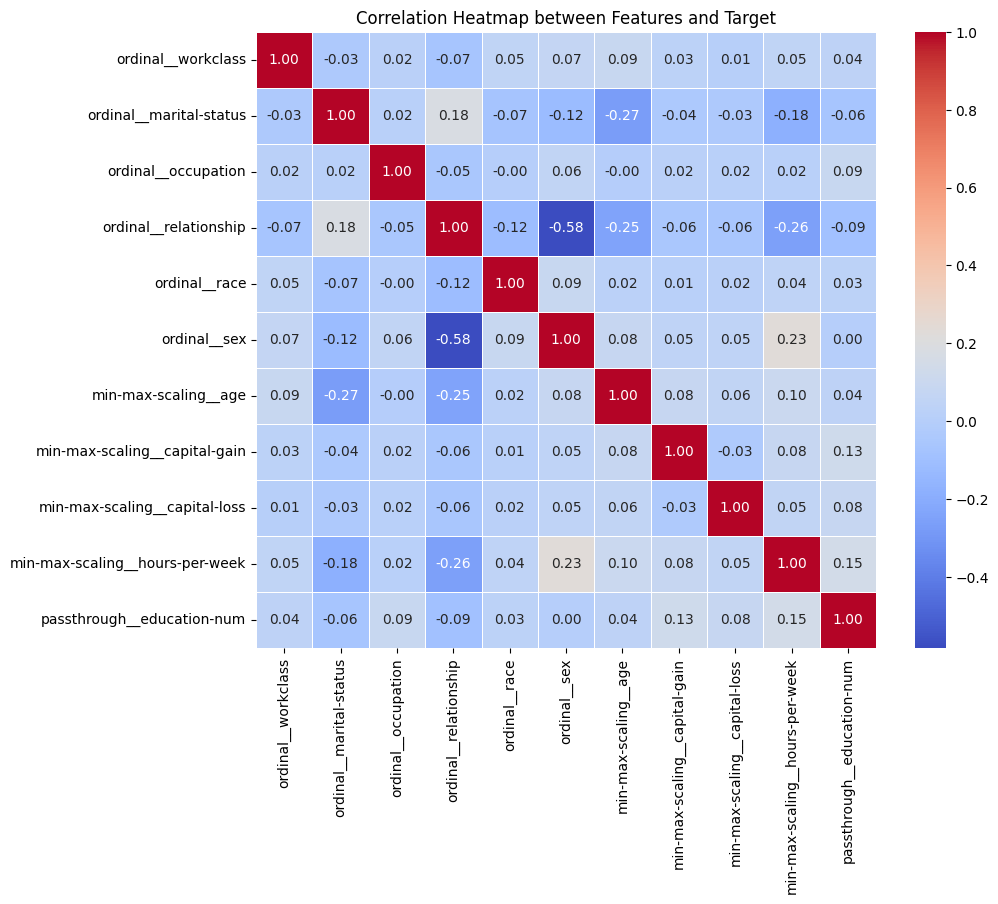

In [63]:
def visualize(data: pd.DataFrame, ct: ColumnTransformer) -> None:
    """
    Show the correlation between different features including target variable via a heatmap

    :param data: Dataset
    :param ct: Chosen transformer
    """
    transformed_df = pd.DataFrame(ct.fit_transform(data.drop('salary', axis=1)), columns=ct.get_feature_names_out())
    # Compute correlation matrix
    corr_matrix = transformed_df.corr()

    plt.figure(figsize=(10,8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

    plt.title('Correlation Heatmap between Features and Target')
    plt.show()

visualize(data, ct)

In [77]:
def apply_model(model, X: list, y: list, display_graphs:bool=False) -> None:
    """
    Applies a model to feature array X and labels y and
    wraps the model and steps into a Pipeline

    :param model: The chosen model
    :param X: The features of all (train and test) samples
    :param y: The label of all (train and test) samples
    :return: Evaluate the model and return the results
    """
    assert len(X) == len(y) == 2
    X_train, X_test = X
    y_train, y_test = y

    pipeline = Pipeline(steps=[('t', ct), ('m', model)])
    pipeline.fit(X_train, y_train)

    return evaluate_model(X_test, y_test, pipeline, type(model).__name__, display_graphs)

In [78]:
def show_model_figures(X: list, y: list, y_pred, pipeline: Pipeline, model_name:str) -> None:
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for model: ' + model_name)
    plt.show()

    precision_vals, recall_vals, _ = precision_recall_curve(y, pipeline.predict_proba(X)[:, 1])  # Adjust based on your model's output
    plt.figure(figsize=(5, 4))
    plt.plot(recall_vals, precision_vals, marker='o')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.show()

def evaluate_model(X: list, y: list, pipeline: Pipeline, model_name:str, display_graphs:bool) -> None:
    """
    Applies validation techniques and calculates metrics

    :param X: The features
    :param y: The labels
    :param pipeline: The chosen pipeline
    :param model_name: The name of the chosen model
    :param display_graphs: Display the graphs
    """
    y_pred = pipeline.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print('\n')

    if display_graphs:
        show_model_figures(X, y, y_pred, pipeline, model_name)

    return accuracy, precision, recall


In [72]:
# Split into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('salary', axis=1), data['salary'], test_size=0.2, random_state=42)

models = [LinearDiscriminantAnalysis(), LogisticRegression(random_state=42, max_iter=500),
          DecisionTreeClassifier(random_state=42), MLPClassifier(random_state=42)]

In [67]:
X = [X_train, X_test]
y = [y_train, y_test]
print("Running models on the dataset")
for model in models:
    print("Running model: " + str(type(model).__name__))
    apply_model(model, X, y)

Running models on the dataset
Running model: LinearDiscriminantAnalysis
Accuracy: 0.81
Precision: 0.80
Recall: 0.81


Running model: LogisticRegression
Accuracy: 0.82
Precision: 0.81
Recall: 0.82


Running model: DecisionTreeClassifier
Accuracy: 0.82
Precision: 0.82
Recall: 0.82


Running model: MLPClassifier
Accuracy: 0.85
Precision: 0.84
Recall: 0.85




### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0.


In [68]:
"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def pertubate(fraction: float, data: pd.DataFrame) -> pd.DataFrame:
    copy = data.to_frame().copy()

    num_perturbations = int(fraction * len(copy))
    indices = np.random.choice(copy.index, size=num_perturbations, replace=False)

    copy.loc[indices, 'salary'] = abs(1 - copy.loc[indices, 'salary'])
    return copy['salary']

#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot.

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

In [79]:
model_names = [type(model).__name__ for model in models]
accuracy_data = {model_name: [] for model_name in model_names}
precision_data = {model_name: [] for model_name in model_names}
recall_data = {model_name: [] for model_name in model_names}


for frac_perturbation in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    y = [pertubate(frac_perturbation, y_train), pertubate(frac_perturbation, y_test)]
    print("Running models on %s fraction of perturbed labels" % frac_perturbation)
    for model, model_name in zip(models, model_names):
        print("Running model: " + str(type(model).__name__))
        accuracy, precision, recall = apply_model(model, X, y)
        accuracy_data[model_name].append(accuracy)
        precision_data[model_name].append(precision)
        recall_data[model_name].append(recall)

Running models on 0 fraction of perturbed labels
Running model: LinearDiscriminantAnalysis
Accuracy: 0.81
Precision: 0.80
Recall: 0.81


Running model: LogisticRegression
Accuracy: 0.82
Precision: 0.81
Recall: 0.82


Running model: DecisionTreeClassifier
Accuracy: 0.82
Precision: 0.82
Recall: 0.82


Running model: MLPClassifier
Accuracy: 0.85
Precision: 0.84
Recall: 0.85


Running models on 0.1 fraction of perturbed labels
Running model: LinearDiscriminantAnalysis
Accuracy: 0.75
Precision: 0.73
Recall: 0.75


Running model: LogisticRegression
Accuracy: 0.75
Precision: 0.74
Recall: 0.75


Running model: DecisionTreeClassifier
Accuracy: 0.70
Precision: 0.69
Recall: 0.70


Running model: MLPClassifier
Accuracy: 0.78
Precision: 0.77
Recall: 0.78


Running models on 0.2 fraction of perturbed labels
Running model: LinearDiscriminantAnalysis
Accuracy: 0.68
Precision: 0.67
Recall: 0.68


Running model: LogisticRegression
Accuracy: 0.68
Precision: 0.67
Recall: 0.68


Running model: DecisionTree

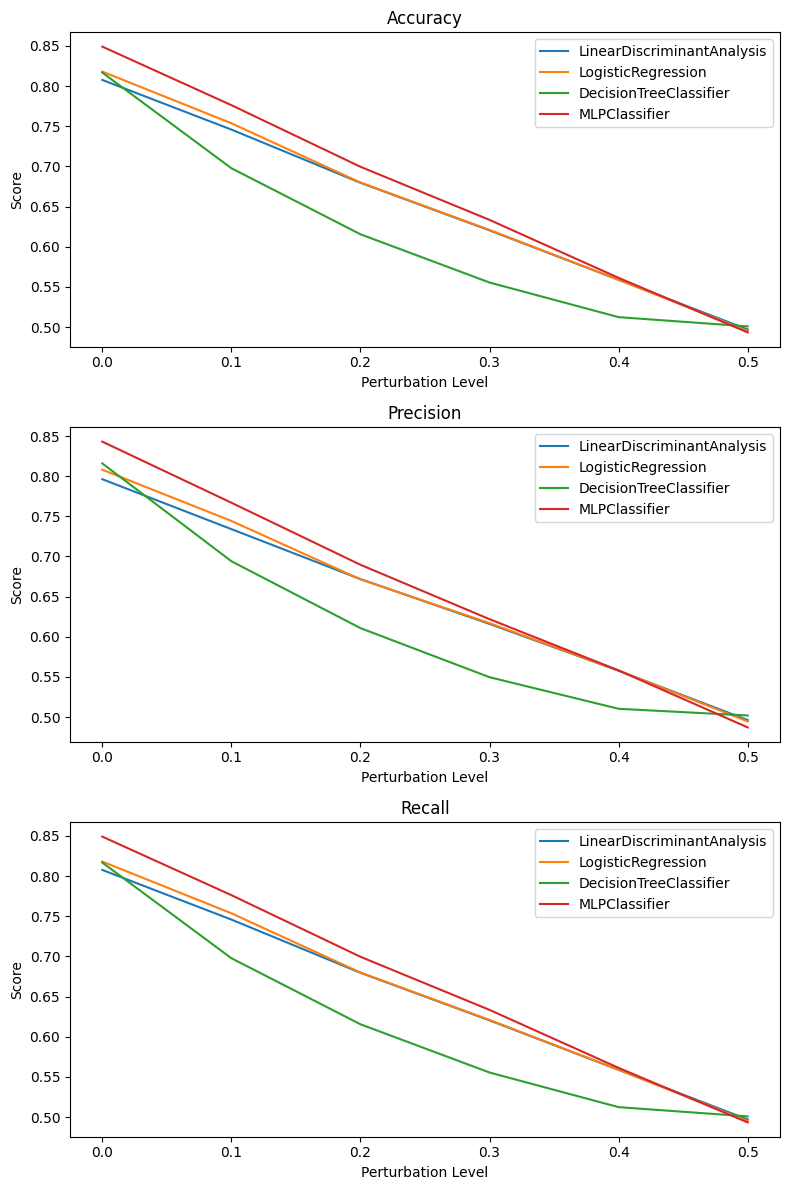

In [82]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
perturbation_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

for model_name in model_names:
    axes[0].plot(perturbation_levels, accuracy_data[model_name], label=model_name)
    axes[1].plot(perturbation_levels, precision_data[model_name], label=model_name)
    axes[2].plot(perturbation_levels, recall_data[model_name], label=model_name)

axes[0].set_title('Accuracy')
axes[1].set_title('Precision')
axes[2].set_title('Recall')

for ax in axes:
    ax.set_xlabel('Perturbation Level')
    ax.set_ylabel('Score')
    ax.legend()

# plt.legend()
plt.tight_layout()
plt.show()

Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion.

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

Now we have a some datasets that are related to each other.

**Altogether they are the same as the adult dataset used in the part 1 of the assignment.**

In this scenario, one can see the utility of the subsets of data can impact the outcome of the task from the previous section.

Because the data is split up, we want to be able to re-construct the data through data discovery.

As data discovery will allow you to be able to find relations that can be used to reconstruct the entire dataset.

Implement a method of your choice to perform the data discovery to be able to recover the entire dataset from part 1 of the assignment.

In [ ]:
def preprocess_adult_file(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess a file read as of Part 2. This includes
    - Renaming the "id" field
    - Making sure the data is sorted on the id
    """
    dataset = dataset.rename(columns={"Unnamed: 0": "id"}) # Process indices
    dataset = dataset.sort_values(by='id') # Ensure data is sorted by index
    return dataset

In [ ]:
# Import the files
import os
def import_folder(folder_path: str, print_cols_per_file=False) -> (list[pd.DataFrame], list[str]):
    """
    Imports the datasets in the specified folder.
    :param folder_path: The folder path
    :param print_cols_per_file: Whether to print debug info about each file
    :return: The list of datasets and the list of their names
    """
    files_list = []
    f_names = []

    for _, filename in enumerate(os.listdir(folder_path)):
        curr_file = preprocess_adult_file(import_csv(folder_path + filename))

        files_list.append(curr_file)
        f_names.append(filename)
        if print_cols_per_file:
            print(unique_vals_per_col(curr_file))
            print('\n')
    assert len(files_list) == len(f_names)
    return files_list, f_names

files, file_names = import_folder('data_adult_discovery/')

In [ ]:
def is_matching_vals(dataset1: pd.DataFrame, dataset2: pd.DataFrame) -> bool:
    """
    Checks if all the values of the matching columns are identical
    """
    if dataset1.shape[0] != dataset2.shape[0]: # number of rows match
        return False

    matching_cols = has_matching_col_names(dataset1, dataset2)
    if len(matching_cols) == 0: # if no columns match names
        return False

    for col in matching_cols:
        if not dataset1[col].equals(dataset2[col]):
            return False

    return True

def has_matching_col_names(dataset1: pd.DataFrame, dataset2: pd.DataFrame) -> set:
    """
    Check if two datasets are related. Only checks for matching column names.
    :param dataset1: Dataset 1
    :param dataset2: Dataset 2
    :return: a list of related columns
    """
    col_names1 = set(dataset1.columns)
    col_names2 = set(dataset2.columns)

    return col_names1 & col_names2

In [ ]:
def discovery_algorithm(datasets: list[pd.DataFrame], dataset_names: list[str]) -> list:
    """
    Performs data discovery to find related datasets
    :param datasets List of datasets
    :param dataset_names List of dataset names
    :return: List of pairs of related datasets and the matching column names
    """
    related_datasets = []
    for i in range(len(datasets)):
        for j in range(i + 1, len(datasets)):
            if is_matching_vals(datasets[i], datasets[j]):
                related_datasets.append((i, j,                                              #indices
                                         dataset_names[i], dataset_names[j],                #file names
                                         has_matching_col_names(datasets[i], datasets[j]))) #matching columns
    return related_datasets

In [ ]:
def merge_matching_datasets(datasets: list[pd.DataFrame], dataset_names: list[str]) -> list[pd.DataFrame]:
    """
    Merges the matching datasets.
    :param datasets: List of datasets
    :param dataset_names: List of dataset names
    :return: A list of merged datasets. These now form different portions of the combined total dataset
    """
    merged_datasets = []
    related_datasets = discovery_algorithm(datasets, dataset_names)
    for i, j, _, _, matching_cols_set in related_datasets:
        merged_datasets.append(pd.merge(datasets[i], datasets[j], how='inner', on=list(matching_cols_set)))

    return merged_datasets


In [ ]:
# Merge similar datasets into chunks
chunks = merge_matching_datasets(files, file_names)

for i, chunk in enumerate(chunks):
    chunk = drop_nulls(preprocess_adult_dataset(chunk, ['education', 'fnlwgt', 'native-country', 'first_name', 'last_names', 'id']))
    print("Running models on chunk #%d" % i)
    for model in models:
        print("Running model: " + str(type(model).__name__))
        x_train, x_test, y_train, y_test = train_test_split(chunk.drop('salary', axis=1), chunk['salary'], test_size=0.2, random_state=42)
        apply_model(model, [x_train, x_test], [y_train, y_test])

### Evaluation

Following the same workflow as Part 1 of the assignment, you will need to perform the steps once again.
This means that with the difference in setting, there has now been a change in the data loading portion of the workflow.

<!-- While performing data discovery, one can check how having more data of different relations can effect the outcome of the downstream task. -->

As you perform the act of data discovery you will be piecing the data back together one by one by finding the relation between the datasets.

As you piece the data back together, the entire dataset will be available in varying portions.

Then using the different portions of available data, fit the models that were used previously, and examine the results when testing on the appropriate data from the testing samples.

*The dataset from part 1 can be treated as the groundtruth, so you can try and random sample from that dataset to produce the testing samples that can be used in this part.*

***

One can also evaluate on the effect of incorrectness of data discovery.

Suppose what you have done for data discovery is correct, this means the relations that are found are correct.

What if you perform a perturbation on the relations between the files?

This would mean the dataset will be incorrectly joined, do you think there will be an impact on the outcome of the model that will be trained and then tested on the groudtruth dataset?

What would the effect be on the downstream tasks as mentioned in the machine learning workflow such as data pre-processing, machine learning model training and testing?

This can be evaluated in the same way as above.

In [ ]:
# Reconstruct the adult dataset from the chunks
def reconstruct_dataset(chunks: list[pd.DataFrame]) -> pd.DataFrame:
    """
    Reconstructs the dataset from the chunks.
    :param chunks: The chunks
    :return: The reconstructed dataset
    """
    return pd.concat(chunks).sort_values(by='id')

In [ ]:
def circular_shift(dataframe: pd.DataFrame, shift_amount: int = 1) -> pd.DataFrame:
    return pd.concat([dataframe.iloc[-shift_amount:], dataframe.iloc[:-shift_amount]], ignore_index=True)

def pertubate_datasets(datasets: list[pd.DataFrame], dataset_names: list[str], fraction: float) -> pd.DataFrame:
    """
    Merges datasets correctly, drops a fraction of the data, and then merges incorrectly by shifting indices.

    :param datasets: List of datasets
    :param dataset_names: List of dataset names
    :param fraction: Fraction of data to drop and then join incorrectly (between 0 and 1).
    :return: A list of merged datasets (incorrectly joined with shifted rows).
    """
    assert 0 <= fraction <= 1
    merged_datasets = []
    related_datasets = discovery_algorithm(datasets, dataset_names)

    for i, j, _, _, matching_cols_set in related_datasets:
        merged = pd.merge(datasets[i], datasets[j], how='inner', on=list(matching_cols_set))

        # Randomly drop a fraction of the data
        num_rows_to_drop = int(fraction * len(merged))
        dropped_indices = np.random.choice(merged.index, size=num_rows_to_drop, replace=False)
        correctly_joined = merged.drop(index=dropped_indices)

        # Incorrectly join the dropped data by shifting one table's rows by 1
        incorrect_df1 = datasets[i].iloc[dropped_indices]
        incorrect_df2 = circular_shift(datasets[j].iloc[dropped_indices])
        incorrectly_joined = pd.merge(incorrect_df1, incorrect_df2, how='inner', on=list(matching_cols_set))

        merged = pd.concat([correctly_joined, incorrectly_joined], ignore_index=True)
        merged_datasets.append(merged)
        merged.to_csv('kurac_%d_%d.csv' % (i, j))
    return merged_datasets

c = pertubate_datasets(files, file_names, 1)

In [ ]:
# Sample a fraction of the full adult dataset as test samples from Part 1
test_samples = data.sample(frac=0.2)

# Do some testing on performing various degrees of incorrect data discovery.
print("Running models on the correctly merged dataset")
for fraction in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    x = reconstruct_dataset(pertubate_datasets(files, file_names, fraction))
    x = drop_nulls(preprocess_adult_dataset(x, ['education', 'fnlwgt', 'native-country', 'first_name', 'last_names', 'id']))

    x_train, x_test = x.iloc[:, :-1], test_samples.iloc[:, :-1]
    y_train, y_test = x.iloc[:, -1], test_samples.iloc[:, -1]

    for model in models:
        print("Running model: " + str(type(model).__name__))
        apply_model(model, [x_train, x_test], [y_train, y_test])

## Discussions

1)  Discuss the different effects of the results of the data discovery results on various downstream tasks in the machine learning workflow.
    As stated previously, this is effecting the data loading portion of the ML workflow.

2)  Discuss also what aspects need to be considered when performing data discovery and evaluating the results of data discovery.

Max. 400 words

The perturbations that performed for part 1 and 2 are all data quality issues.

3) Discuss on the effects of data quality and how you may attempt to identify and solve these issues?

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words